## CartPole-v1, solved with Q-learning

In [1]:
import numpy as np
import torch
import random
from matplotlib import pylab as plt
import gym
from collections import deque

In [2]:
# Environment test
env = gym.make("CartPole-v1")
state = env.reset()
for i in range(100):
    env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    print("State: ", env.state)
    print("Action taken: ", action)
    print("Reward: ", reward)
    
    if done:
        state = env.reset()
        
env.close()
env.reset()

State:  (0.044329487301547954, -0.20634464778801176, 0.003437947680200324, 0.2919949831335714)
Action taken:  0
Reward:  1.0
State:  (0.04020259434578772, -0.4015154490557912, 0.009277847342871752, 0.5857602095501621)
Action taken:  0
Reward:  1.0
State:  (0.0321722853646719, -0.2065246705271426, 0.02099305153387499, 0.2960142780315271)
Action taken:  1
Reward:  1.0
State:  (0.028041791954129047, -0.40193950926639377, 0.026913337094505534, 0.5952434516415168)
Action taken:  0
Reward:  1.0
State:  (0.02000300176880117, -0.20720436463234426, 0.03881820612733587, 0.31115808328230715)
Action taken:  1
Reward:  1.0
State:  (0.015858914476154284, -0.012656338061286715, 0.04504136779298201, 0.030965568938813248)
Action taken:  1
Reward:  1.0
State:  (0.01560578771492855, 0.18179172445148348, 0.04566067917175828, -0.24717302850366957)
Action taken:  1
Reward:  1.0
State:  (0.019241622203958218, 0.37623282308923045, 0.04071721860168488, -0.5251111114746799)
Action taken:  1
Reward:  1.0
State: 

State:  (-0.09519688791443609, -0.5772468571812358, 0.11874618124570127, 0.8454551298223542)
Action taken:  1
Reward:  1.0
State:  (-0.1067418250580608, -0.383927843945041, 0.13565528384214837, 0.5923480419387674)
Action taken:  1
Reward:  1.0
State:  (-0.11442038193696162, -0.19093958417611515, 0.1475022446809237, 0.34528559259938985)
Action taken:  1
Reward:  1.0
State:  (-0.11823917362048392, 0.0018099808192218458, 0.1544079565329115, 0.10250935366126107)
Action taken:  1
Reward:  1.0
State:  (-0.11820297400409949, -0.19514892240905937, 0.15645814360613672, 0.4396485738955493)
Action taken:  0
Reward:  1.0
State:  (-0.12210595245228067, -0.39209898950507915, 0.16525111508404772, 0.7772764225014599)
Action taken:  0
Reward:  1.0
State:  (-0.12994793224238227, -0.19958828539252976, 0.18079664353407693, 0.5408072127090148)
Action taken:  1
Reward:  1.0
State:  (-0.13393969795023286, -0.007406446764606944, 0.19161278778825722, 0.3100981892913136)
Action taken:  1
Reward:  1.0
State:  (-

array([ 0.0143975 , -0.03536023,  0.03019354, -0.01588006])

In [3]:
# Setup model
l1 = 4
l2 = 150
l3 = 100
l4 = 2
gamma = 0.9
epsMin, epsMax = 0.2, 0.7
epsilon = epsMax
learning_rate = 1e-3

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [4]:
# Train phase
epochs = 1000
losses = []

for i in range(epochs):
    state_ = np.asarray(env.state, dtype = 'float') + np.random.rand(1, l1) / 10.0
    state1 = torch.from_numpy(state_).float()
    done = False
    lossesEp = []
    while not done:
        qval = model(state1)
        qval_ = qval.data.numpy()
#         print('Qs: ', qval_)
        
        if (random.random() < epsilon):
#             print('Sample random')
            action = np.random.randint(0, 2)
        else:
#             print('Sample Q')
            action = np.argmax(qval_)
        
        state, reward, done, _ = env.step(action)
#         print('Action: ', action)
#         print('State: ', state)
        
        state2_ = np.asarray(state, dtype = 'float') + np.random.rand(1, l1) / 10.0
        state2 = torch.from_numpy(state2_).float()
        
        with torch.no_grad():
            newQ = model(state2)
            
        maxQ = torch.max(newQ)
        
        Y = reward + (gamma * maxQ) if not done else reward
        
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action] 
        
        loss = loss_fn(X, Y)
#         print('Episode: ', i, '\t', 'Loss: ', loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        lossesEp.append(loss.item())
        optimizer.step()
        state1 = state2
    
    # Accumulate loss
    lossEpMean = sum(lossesEp) / len(lossesEp)
    losses.append(lossEpMean)
    print('Episode', i + 1, '\t', 'Loss:', lossEpMean)
    
    # Reset environment
    env.reset()
    
    if epsilon > epsMin:
        epsilon -= ((epsMax - epsMin) / epochs)

c:\users\dan\appdata\local\programs\python\python36\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 1 	 Loss: 1.357963216304779
Episode 2 	 Loss: 1.1754929146084647
Episode 3 	 Loss: 1.3321407416771198
Episode 4 	 Loss: 1.6417566257027478
Episode 5 	 Loss: 1.9325968907679423
Episode 6 	 Loss: 2.7458291677854327
Episode 7 	 Loss: 2.9130269313796555
Episode 8 	 Loss: 5.206754549251248
Episode 9 	 Loss: 4.122013336843605
Episode 10 	 Loss: 2.5567238593256385
Episode 11 	 Loss: 1.9800705217957413
Episode 12 	 Loss: 7.742498792392351
Episode 13 	 Loss: 2.3858004656827285
Episode 14 	 Loss: 8.461052374985929
Episode 15 	 Loss: 5.988026178800142
Episode 16 	 Loss: 5.794602472955982
Episode 17 	 Loss: 6.635998844410534
Episode 18 	 Loss: 5.028271676558587
Episode 19 	 Loss: 14.323439782671631
Episode 20 	 Loss: 3.509081748314202
Episode 21 	 Loss: 5.641496889836465
Episode 22 	 Loss: 4.727447365986943
Episode 23 	 Loss: 4.509004695008376
Episode 24 	 Loss: 1.186374766705067
Episode 25 	 Loss: 1.8330468861278955
Episode 26 	 Loss: 6.485600404897758
Episode 27 	 Loss: 5.933371885987526

Episode 217 	 Loss: 1.0841810814870134
Episode 218 	 Loss: 2.054096310673391
Episode 219 	 Loss: 0.4243459539224176
Episode 220 	 Loss: 2.1870667967152606
Episode 221 	 Loss: 0.22736771255635435
Episode 222 	 Loss: 1.9449909123442402
Episode 223 	 Loss: 1.1118227039308597
Episode 224 	 Loss: 0.8693531514993603
Episode 225 	 Loss: 0.7369603403032631
Episode 226 	 Loss: 3.4445332501252945
Episode 227 	 Loss: 0.4934373386949693
Episode 228 	 Loss: 2.5416255767146745
Episode 229 	 Loss: 1.8621612608641533
Episode 230 	 Loss: 1.2510203262136201
Episode 231 	 Loss: 0.33645257102373954
Episode 232 	 Loss: 1.163456609800712
Episode 233 	 Loss: 0.3665580172094495
Episode 234 	 Loss: 0.5894556316070586
Episode 235 	 Loss: 2.356952867625902
Episode 236 	 Loss: 0.516040028552632
Episode 237 	 Loss: 0.9158883143830951
Episode 238 	 Loss: 3.2755980075336995
Episode 239 	 Loss: 1.1641813337752722
Episode 240 	 Loss: 0.8730697156095717
Episode 241 	 Loss: 2.551701099378988
Episode 242 	 Loss: 0.398206

Episode 431 	 Loss: 2.12688845721589
Episode 432 	 Loss: 0.5667211122791416
Episode 433 	 Loss: 2.892716746185033
Episode 434 	 Loss: 0.6823830787223415
Episode 435 	 Loss: 1.3097383759031072
Episode 436 	 Loss: 4.082940377566653
Episode 437 	 Loss: 0.9232073690897474
Episode 438 	 Loss: 0.8499618548679073
Episode 439 	 Loss: 4.335390692625783
Episode 440 	 Loss: 0.717709979398875
Episode 441 	 Loss: 2.7750647431239486
Episode 442 	 Loss: 0.9825569670927541
Episode 443 	 Loss: 0.9493437644363312
Episode 444 	 Loss: 0.510691781837118
Episode 445 	 Loss: 0.5934962277122608
Episode 446 	 Loss: 0.6237563107434531
Episode 447 	 Loss: 0.6022795860988536
Episode 448 	 Loss: 1.373962113446653
Episode 449 	 Loss: 2.571917078574188
Episode 450 	 Loss: 0.540779488727681
Episode 451 	 Loss: 0.30948471787621257
Episode 452 	 Loss: 0.5217128812073654
Episode 453 	 Loss: 1.4663043033934042
Episode 454 	 Loss: 1.2986957477405667
Episode 455 	 Loss: 0.6485398438980119
Episode 456 	 Loss: 2.055101035932

Episode 642 	 Loss: 0.17428826341937648
Episode 643 	 Loss: 3.350382755765872
Episode 644 	 Loss: 1.0818544997160975
Episode 645 	 Loss: 0.762580677257994
Episode 646 	 Loss: 2.56252726034269
Episode 647 	 Loss: 0.32915653883687984
Episode 648 	 Loss: 1.968872024240475
Episode 649 	 Loss: 0.2642227060114697
Episode 650 	 Loss: 0.2647081746743283
Episode 651 	 Loss: 1.5838981097079918
Episode 652 	 Loss: 0.5557291477542152
Episode 653 	 Loss: 0.33906955308918824
Episode 654 	 Loss: 0.20876889129947443
Episode 655 	 Loss: 0.27059154143267516
Episode 656 	 Loss: 2.8685357034468324
Episode 657 	 Loss: 0.24450926866007686
Episode 658 	 Loss: 0.6032126168223035
Episode 659 	 Loss: 1.0591918285082405
Episode 660 	 Loss: 0.19531763525950427
Episode 661 	 Loss: 0.14536600896402282
Episode 662 	 Loss: 0.31301680800068915
Episode 663 	 Loss: 0.42705773436949435
Episode 664 	 Loss: 0.2507509127310241
Episode 665 	 Loss: 0.4431343180791561
Episode 666 	 Loss: 1.6410686757391024
Episode 667 	 Loss: 

Episode 851 	 Loss: 0.11978019450621663
Episode 852 	 Loss: 5.319406441257645
Episode 853 	 Loss: 0.25211254943096356
Episode 854 	 Loss: 1.6621542072800153
Episode 855 	 Loss: 0.9766166042904686
Episode 856 	 Loss: 1.2542495905900768
Episode 857 	 Loss: 0.1295772831148012
Episode 858 	 Loss: 0.25238999424982467
Episode 859 	 Loss: 3.273339605237617
Episode 860 	 Loss: 2.2990800583036615
Episode 861 	 Loss: 1.917878993636155
Episode 862 	 Loss: 0.12919944530125682
Episode 863 	 Loss: 0.08533347844567771
Episode 864 	 Loss: 1.1001691830654938
Episode 865 	 Loss: 0.12147148109208326
Episode 866 	 Loss: 0.22842192909559267
Episode 867 	 Loss: 0.10361573158723263
Episode 868 	 Loss: 2.0326344126175777
Episode 869 	 Loss: 0.17583898704049986
Episode 870 	 Loss: 0.10421657044888646
Episode 871 	 Loss: 0.1741205995617793
Episode 872 	 Loss: 0.37945514046130785
Episode 873 	 Loss: 0.13311512349263832
Episode 874 	 Loss: 0.1125069121483405
Episode 875 	 Loss: 0.7781954013619125
Episode 876 	 Lo

Text(0, 0.5, 'Mean Loss')

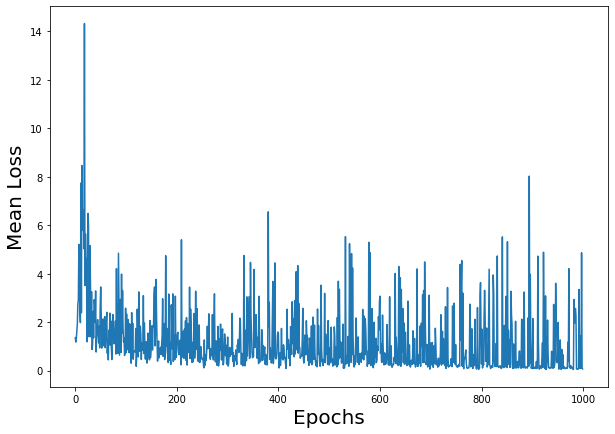

In [5]:
plt.figure(figsize = (10, 7))
plt.plot(losses)
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Mean Loss', fontsize = 20)

## Looks noisy. What's happened?

In [6]:
# Test phase
episodes = 100
rewardsTotal = []

for i in range(episodes):
    done = False
    rewardsEp = []
#     print(f"********** Episode {i} **********")
    while not done:
        # Render environment
        env.render()
        
        state_ = np.asarray(env.state, dtype = 'float') + np.random.rand(1, l1) / 10.0
        state = torch.from_numpy(state_).float()
        
        qval = model(state)
        qval_ = qval.data.numpy()
#         print('Qs: ', qval_)
        
        action = np.argmax(qval_)
        
        state, reward, done, _ = env.step(action)
#         print(f'Action: {action}\t Reward: {reward}')
#         print('State: ', state)
        
        # Store reward
        rewardsEp.append(reward)
        
    # Accumulate reward
    rewardTotal = sum(rewardsEp)
    rewardsTotal.append(rewardTotal)
    print('Episode', i, '\t', 'Total reward:', rewardTotal)
    
    
    # Reset environment
    env.reset()
    
env.close()
    
rewardTotalMean = sum(rewardsTotal) / len(rewardsTotal)
print('\nTotal mean reward:', rewardTotalMean)

Episode 0 	 Total reward: 182.0
Episode 1 	 Total reward: 171.0
Episode 2 	 Total reward: 181.0
Episode 3 	 Total reward: 170.0
Episode 4 	 Total reward: 163.0
Episode 5 	 Total reward: 166.0
Episode 6 	 Total reward: 183.0
Episode 7 	 Total reward: 181.0
Episode 8 	 Total reward: 162.0
Episode 9 	 Total reward: 172.0
Episode 10 	 Total reward: 175.0
Episode 11 	 Total reward: 156.0
Episode 12 	 Total reward: 167.0
Episode 13 	 Total reward: 159.0
Episode 14 	 Total reward: 153.0
Episode 15 	 Total reward: 147.0
Episode 16 	 Total reward: 163.0
Episode 17 	 Total reward: 150.0
Episode 18 	 Total reward: 181.0
Episode 19 	 Total reward: 154.0
Episode 20 	 Total reward: 171.0
Episode 21 	 Total reward: 180.0
Episode 22 	 Total reward: 178.0
Episode 23 	 Total reward: 174.0
Episode 24 	 Total reward: 156.0
Episode 25 	 Total reward: 189.0
Episode 26 	 Total reward: 175.0
Episode 27 	 Total reward: 158.0
Episode 28 	 Total reward: 159.0
Episode 29 	 Total reward: 171.0
Episode 30 	 Total r

## Seems like it is learning but not sufficiently. Let's try with experience replay to not forget past situations.

In [7]:
# Setup model
l1 = 4
l2 = 150
l3 = 100
l4 = 2
gamma = 0.9
epsMin, epsMax = 0.2, 0.7
epsilon = epsMax
learning_rate = 1e-3

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [8]:
# Reset environment
env.reset()

# Train phase
epochs = 1000
losses = []

# Define experience replay params
bufferSize = epochs // 5
batchSize = bufferSize // 4
replay = deque(maxlen = bufferSize)

for i in range(epochs):
    state_ = np.asarray(env.state, dtype = 'float') + np.random.rand(1, l1) / 10.0
    state1 = torch.from_numpy(state_).float()
    done = False
    lossesEp = []
    while not done:
        qval = model(state1)
        qval_ = qval.data.numpy()
#         print('Qs: ', qval_)
        
        if (random.random() < epsilon):
#             print('Sample random')
            action = np.random.randint(0, 2)
        else:
#             print('Sample Q')
            action = np.argmax(qval_)
        
        state, reward, done, _ = env.step(action)
#         print('Action: ', action)
#         print('State: ', state)
        
        state2_ = np.asarray(state, dtype = 'float') + np.random.rand(1, l1) / 10.0
        state2 = torch.from_numpy(state2_).float()
        
        # Store experience
        exp = (state1, action, reward, state2, done)
        replay.append(exp)
        
        state1 = state2
        
        # Start training if enough experience
        if len(replay) > batchSize:
            batch = random.sample(replay, batchSize)
            state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in batch])
            action_batch = torch.Tensor([a for (s1, a, r, s2, d) in batch])
            reward_batch = torch.Tensor([r for (s1, a, r, s2, d) in batch])
            state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in batch])
            done_batch = torch.Tensor([d for (s1, a, r, s2, d) in batch])
            
            Q1 = model(state1_batch)
            
            with torch.no_grad():
                Q2 = model(state2_batch)
        
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2, dim = 1)[0])
            X = Q1.gather(dim = 1, index = action_batch.long().unsqueeze(dim = 1)).squeeze()
        
            loss = loss_fn(X, Y.detach())
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Store loss
            lossesEp.append(loss.item())
    
    # Accumulate loss
    if len(lossesEp) > 0:
        lossEpMean = sum(lossesEp) / len(lossesEp)
        losses.append(lossEpMean)
        print('Episode', i + 1, '\t', 'Loss:', lossEpMean)
    
    # Reset environment
    env.reset()
    
    if epsilon > epsMin:
        epsilon -= ((epsMax - epsMin) / epochs)

Episode 3 	 Loss: 0.989028811454773
Episode 4 	 Loss: 0.9724642712136974
Episode 5 	 Loss: 1.3759382229584913
Episode 6 	 Loss: 2.7418682364856495
Episode 7 	 Loss: 4.123402876513345
Episode 8 	 Loss: 6.740702111274004
Episode 9 	 Loss: 5.006430456271539
Episode 10 	 Loss: 5.3762436787287395
Episode 11 	 Loss: 11.221757985651493
Episode 12 	 Loss: 37.75528360815609
Episode 13 	 Loss: 72.72807102203369
Episode 14 	 Loss: 56.99032095500401
Episode 15 	 Loss: 25.710318453171674
Episode 16 	 Loss: 19.797939630655144
Episode 17 	 Loss: 14.271771362849645
Episode 18 	 Loss: 8.244769191741943
Episode 19 	 Loss: 7.512590116924709
Episode 20 	 Loss: 4.295114206231159
Episode 21 	 Loss: 2.7709595024585725
Episode 22 	 Loss: 2.2620624636902527
Episode 23 	 Loss: 3.3521447558152047
Episode 24 	 Loss: 2.584289535880089
Episode 25 	 Loss: 2.777644228935242
Episode 26 	 Loss: 2.4101706484953564
Episode 27 	 Loss: 1.963790862224041
Episode 28 	 Loss: 1.4865611162665602
Episode 29 	 Loss: 1.36457139162

Episode 216 	 Loss: 0.6213071583991959
Episode 217 	 Loss: 0.6408443590005238
Episode 218 	 Loss: 0.5193926681052236
Episode 219 	 Loss: 0.4912353651598096
Episode 220 	 Loss: 0.4399485413071721
Episode 221 	 Loss: 0.3077109401876276
Episode 222 	 Loss: 0.32924422048605406
Episode 223 	 Loss: 0.4276327388260954
Episode 224 	 Loss: 0.46231668970801615
Episode 225 	 Loss: 0.25654397503999266
Episode 226 	 Loss: 0.22121103728810945
Episode 227 	 Loss: 0.39775411890198786
Episode 228 	 Loss: 0.7404011364037894
Episode 229 	 Loss: 0.769826685770964
Episode 230 	 Loss: 0.8614443345222531
Episode 231 	 Loss: 0.7024331066538306
Episode 232 	 Loss: 0.4047369377856905
Episode 233 	 Loss: 0.7297432191669941
Episode 234 	 Loss: 0.7958692215928217
Episode 235 	 Loss: 0.5522220367017914
Episode 236 	 Loss: 0.4833404099748981
Episode 237 	 Loss: 0.37456890490526956
Episode 238 	 Loss: 0.4124477691948414
Episode 239 	 Loss: 0.6833842627026818
Episode 240 	 Loss: 0.6465510252644034
Episode 241 	 Loss: 

Episode 428 	 Loss: 0.7831860863300691
Episode 429 	 Loss: 0.47640606698275795
Episode 430 	 Loss: 0.24997233659295098
Episode 431 	 Loss: 0.23745295068098082
Episode 432 	 Loss: 0.1757868040830661
Episode 433 	 Loss: 0.3603520196947185
Episode 434 	 Loss: 0.22647890376467858
Episode 435 	 Loss: 0.6454196158849018
Episode 436 	 Loss: 0.5828985082251685
Episode 437 	 Loss: 1.4337571178163802
Episode 438 	 Loss: 0.8883623833006079
Episode 439 	 Loss: 0.68083122785551
Episode 440 	 Loss: 0.48800584469756036
Episode 441 	 Loss: 0.5835601257265739
Episode 442 	 Loss: 0.3964717893728188
Episode 443 	 Loss: 0.575080293416977
Episode 444 	 Loss: 0.7381773672997951
Episode 445 	 Loss: 0.9881660652160644
Episode 446 	 Loss: 1.094632966177804
Episode 447 	 Loss: 1.1607219446450472
Episode 448 	 Loss: 1.205911283309643
Episode 449 	 Loss: 0.8985036170404208
Episode 450 	 Loss: 0.9091231737818036
Episode 451 	 Loss: 0.3240545369332006
Episode 452 	 Loss: 0.2050701382205538
Episode 453 	 Loss: 0.381

Episode 637 	 Loss: 0.27537766127950614
Episode 638 	 Loss: 0.3055550371989226
Episode 639 	 Loss: 0.3515773346026739
Episode 640 	 Loss: 0.6151370905777988
Episode 641 	 Loss: 0.6280347888960558
Episode 642 	 Loss: 0.9861666008278176
Episode 643 	 Loss: 0.7780984057621523
Episode 644 	 Loss: 0.48479095195800487
Episode 645 	 Loss: 0.226541351819976
Episode 646 	 Loss: 0.12639137830073927
Episode 647 	 Loss: 0.2593743451870978
Episode 648 	 Loss: 0.5246284626838233
Episode 649 	 Loss: 0.5745933881767515
Episode 650 	 Loss: 0.45940181669734775
Episode 651 	 Loss: 0.12751172585462137
Episode 652 	 Loss: 0.14421601316167248
Episode 653 	 Loss: 0.21479806014747352
Episode 654 	 Loss: 0.43812511175870894
Episode 655 	 Loss: 0.4710538221304031
Episode 656 	 Loss: 0.6245692233378822
Episode 657 	 Loss: 0.4339002917210261
Episode 658 	 Loss: 0.5701221350580454
Episode 659 	 Loss: 0.534374410598472
Episode 660 	 Loss: 0.12965171516470897
Episode 661 	 Loss: 0.12155225468786801
Episode 662 	 Los

Episode 845 	 Loss: 0.4811443324338217
Episode 846 	 Loss: 0.06521698892728924
Episode 847 	 Loss: 0.13629713695559462
Episode 848 	 Loss: 0.07255019048766402
Episode 849 	 Loss: 0.051249228650704026
Episode 850 	 Loss: 0.06570611275466424
Episode 851 	 Loss: 0.2125910237332843
Episode 852 	 Loss: 0.46131448696057004
Episode 853 	 Loss: 0.681406996612038
Episode 854 	 Loss: 0.26689206940458393
Episode 855 	 Loss: 0.054379915883003165
Episode 856 	 Loss: 0.24454037840901452
Episode 857 	 Loss: 0.17194791561923922
Episode 858 	 Loss: 0.08479371616197506
Episode 859 	 Loss: 0.02402779762798273
Episode 860 	 Loss: 0.10469945676159113
Episode 861 	 Loss: 0.11649422307272216
Episode 862 	 Loss: 0.050634399347868904
Episode 863 	 Loss: 0.0363140754881456
Episode 864 	 Loss: 0.03963005084854861
Episode 865 	 Loss: 0.3104801878397321
Episode 866 	 Loss: 0.5955595915290443
Episode 867 	 Loss: 0.514606452946152
Episode 868 	 Loss: 0.8390844940554862
Episode 869 	 Loss: 0.45936328589499414
Episode

Text(0, 0.5, 'Mean Loss')

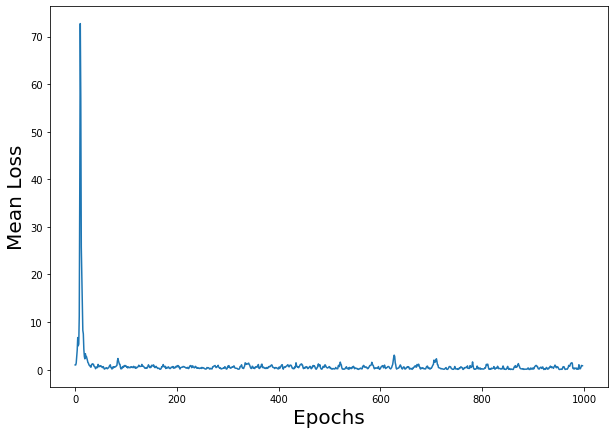

In [9]:
plt.figure(figsize = (10, 7))
plt.plot(losses)
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Mean Loss', fontsize = 20)

## This loss looks very good. Does it mean the model has learnt something?

In [10]:
# Test phase
episodes = 100
rewardsTotal = []

for i in range(episodes):
    done = False
    rewardsEp = []
#     print(f"********** Episode {i} **********")
    while not done:
        # Render environment
        env.render()
        
        state_ = np.asarray(env.state, dtype = 'float') + np.random.rand(1, l1) / 10.0
        state = torch.from_numpy(state_).float()
        
        qval = model(state)
        qval_ = qval.data.numpy()
#         print('Qs: ', qval_)
        
        action = np.argmax(qval_)
        
        state, reward, done, _ = env.step(action)
#         print(f'Action: {action}\t Reward: {reward}')
#         print('State: ', state)
        
        # Store reward
        rewardsEp.append(reward)
        
    # Accumulate reward
    rewardTotal = sum(rewardsEp)
    rewardsTotal.append(rewardTotal)
    print('Episode', i, '\t', 'Total reward:', rewardTotal)
    
    
    # Reset environment
    env.reset()
    
env.close()
    
rewardTotalMean = sum(rewardsTotal) / len(rewardsTotal)
print('\nTotal mean reward:', rewardTotalMean)

Episode 0 	 Total reward: 301.0
Episode 1 	 Total reward: 297.0
Episode 2 	 Total reward: 309.0
Episode 3 	 Total reward: 277.0
Episode 4 	 Total reward: 286.0
Episode 5 	 Total reward: 292.0
Episode 6 	 Total reward: 253.0
Episode 7 	 Total reward: 295.0
Episode 8 	 Total reward: 282.0
Episode 9 	 Total reward: 280.0
Episode 10 	 Total reward: 259.0
Episode 11 	 Total reward: 318.0
Episode 12 	 Total reward: 276.0
Episode 13 	 Total reward: 333.0
Episode 14 	 Total reward: 284.0
Episode 15 	 Total reward: 276.0
Episode 16 	 Total reward: 271.0
Episode 17 	 Total reward: 279.0
Episode 18 	 Total reward: 317.0
Episode 19 	 Total reward: 317.0
Episode 20 	 Total reward: 312.0
Episode 21 	 Total reward: 296.0
Episode 22 	 Total reward: 301.0
Episode 23 	 Total reward: 296.0
Episode 24 	 Total reward: 297.0
Episode 25 	 Total reward: 298.0
Episode 26 	 Total reward: 281.0
Episode 27 	 Total reward: 289.0
Episode 28 	 Total reward: 287.0
Episode 29 	 Total reward: 354.0
Episode 30 	 Total r

## Yay! It has actually learned how to play the game!